In [1]:
from google.colab import files
import cv2
from tensorflow.keras.models import load_model
from IPython.display import display, Image
from google.colab import output
import io
from PIL import Image as PILImage
import base64

# Upload image file (alternative to webcam)
# uploaded = files.upload()

# Load the saved model
model = load_model('/content/mnist_model.keras')

In [2]:
def to_model_shape(x28):
    """Convert 28x28 image to model input shape"""
    x28 = x28.astype("float32") / 255.0
    return x28.reshape(1, 28, 28, 1)

def preprocess_mnist(roi_bgr):
    """Convert the ROI to a 28x28 image and preprocess it for model prediction"""
    # Convert to grayscale and apply blur + threshold
    g = cv2.cvtColor(roi_bgr, cv2.COLOR_BGR2GRAY)
    g = cv2.GaussianBlur(g, (5, 5), 0)
    th = cv2.adaptiveThreshold(
        g, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 2
    )

    # Find contours and select the largest one
    cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None, {"reason": "no contour"}

    c = max(cnts, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    if w * h < 300:  # Reject tiny contours
        return None, {"reason": "small contour"}

    # Prepare the region of interest (ROI) for prediction
    roi = th[y:y+h, x:x+w]
    resized_roi = cv2.resize(roi, (28, 28))
    model_input = to_model_shape(resized_roi)
    return model_input, {"bounding_box": (x, y, w, h)}

In [3]:
from google.colab.output import eval_js

def take_picture():
    """Capture image from webcam using JavaScript"""
    js = """
    async function takePicture() {
        const video = document.createElement('video');
        video.width = 640;
        video.height = 480;
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        video.srcObject = stream;
        await new Promise((resolve) => {
            video.onloadedmetadata = () => { resolve(video); };
        });
        video.play();
        const canvas = document.createElement('canvas');
        canvas.width = 640;
        canvas.height = 480;
        const context = canvas.getContext('2d');
        context.drawImage(video, 0, 0, 640, 480);
        const imageUrl = canvas.toDataURL('image/png');
        stream.getTracks().forEach(track => track.stop());
        return imageUrl;
    }
    takePicture();
    """
    return eval_js(js)

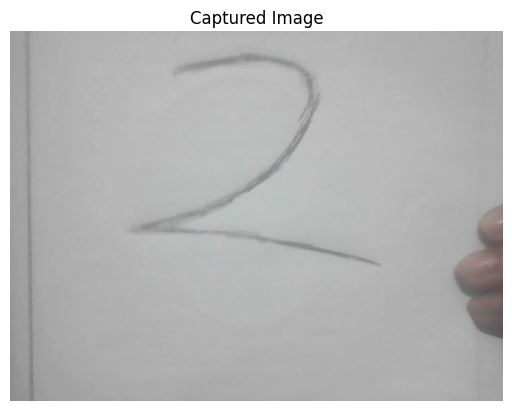

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted Digit: 2
Confidence: 44.58%


In [29]:
# Capture image from webcam
import matplotlib.pyplot as plt
import numpy as np
image_data = take_picture()

# Decode the image data
image_bytes = io.BytesIO(base64.b64decode(image_data.split(',')[1]))

# Convert to PIL image
img = PILImage.open(image_bytes);

# Display the captured image
plt.imshow(img)
plt.title("Captured Image")
plt.axis('off')
plt.show()

# Convert the image to numpy array (OpenCV format)
roi_bgr = np.array(img)

# Preprocess the captured image for prediction
model_input, metadata = preprocess_mnist(roi_bgr)

if model_input is not None:
    # Predict the digit using the model
    prediction = model.predict(model_input)
    predicted_digit = np.argmax(prediction)
    confidence = np.max(prediction) * 100

    # Output the predicted digit
    print(f"Predicted Digit: {predicted_digit}")
    print(f"Confidence: {confidence:.2f}%")
else:
    print(f"Could not process image: {metadata['reason']}")